In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('../data/air-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


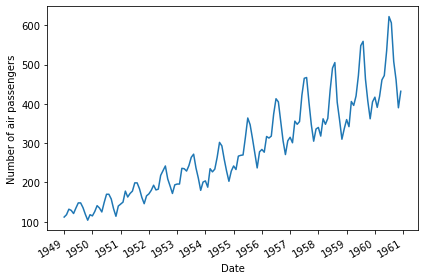

In [3]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH08_F01_peixeiro.png', dpi=300)

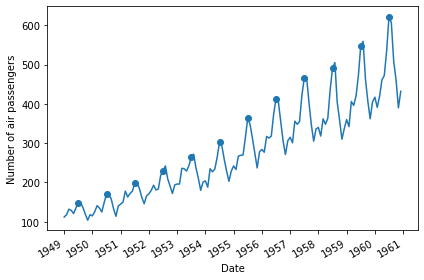

In [5]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'], markevery=np.arange(6, 145, 12), marker='o')
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH08_F02_peixeiro.png', dpi=300)

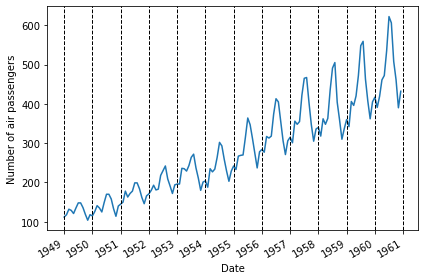

In [5]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
for i in np.arange(0, 145, 12):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH08_F03_peixeiro.png', dpi=300)

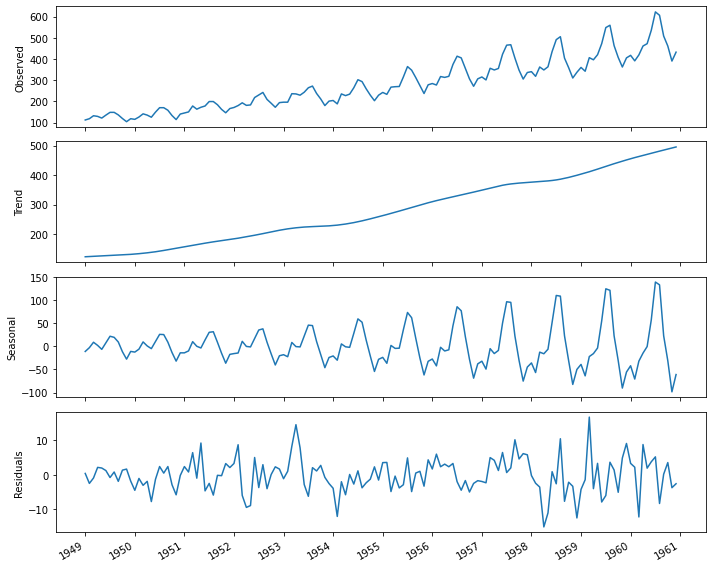

In [6]:
decomposition = STL(df['Passengers'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH08_F04_peixeiro.png', dpi=300)

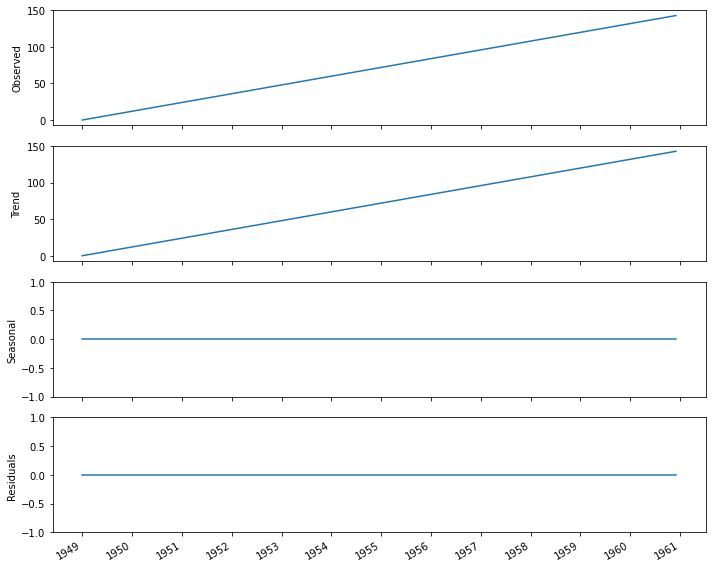

In [7]:
linear_ts = np.arange(0, 144, 1)

decomposition = STL(linear_ts, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax3.set_ylim(-1, 1)

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')
ax4.set_ylim(-1, 1)

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH08_F05_peixeiro.png', dpi=300)

In [3]:
ad_fuller_result = adfuller(df['Passengers'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.8153688792060569
p-value: 0.9918802434376411


In [4]:
df_diff = np.diff(df['Passengers'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.8292668241699928
p-value: 0.05421329028382636


In [5]:
df_diff_seasonal_diff = np.diff(df_diff, n=12)

ad_fuller_result = adfuller(df_diff_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -17.624862360279533
p-value: 3.823046855528954e-30


In [12]:
df_diff2 = np.diff(df_diff, n=1)

ad_fuller_result = adfuller(df_diff2)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -16.384231542468516
p-value: 2.7328918500141235e-29


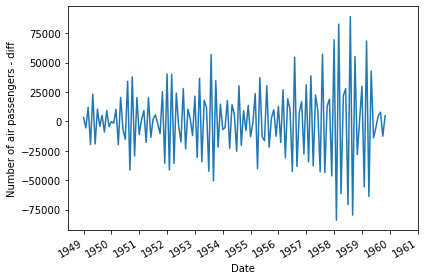

In [13]:
fig, ax = plt.subplots()

ax.plot(df['Month'][13:], eps_diff_seasonal_diff)
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers - diff')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH07_F01_peixeiro.png', dpi=300)

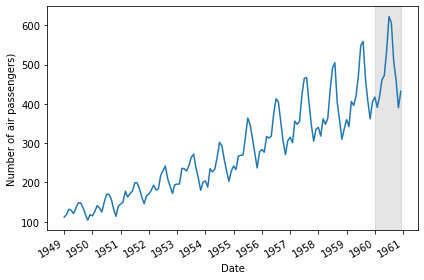

In [14]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers)')
ax.axvspan(132, 143, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH08_F08_peixeiro.png', dpi=300)

In [15]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [16]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [17]:
ps = range(0, 13, 1)
qs = range(0, 13, 1)
Ps = [0]
Qs = [0]

d = 2
D = 0
s = 12

ARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['Passengers'][:-12]

ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)
ARIMA_result_df

  0%|          | 0/169 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(11, 3, 0, 0)",1016.882539
1,"(11, 4, 0, 0)",1019.013048
2,"(11, 5, 0, 0)",1020.428000
3,"(12, 0, 0, 0)",1020.528594
4,"(11, 1, 0, 0)",1021.028226
...,...,...
164,"(5, 0, 0, 0)",1281.732157
165,"(3, 0, 0, 0)",1300.282335
166,"(2, 0, 0, 0)",1302.913196
167,"(1, 0, 0, 0)",1308.152194


In [20]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['Passengers'][:-12]

d = 1
D = 1
s = 12

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 1, 1, 2)",892.244468
1,"(2, 1, 2, 1)",893.456064
2,"(2, 1, 1, 3)",894.099406
3,"(1, 0, 1, 2)",894.286903
4,"(0, 1, 1, 2)",894.992179
...,...,...
250,"(0, 0, 2, 0)",906.940147
251,"(3, 2, 0, 3)",907.181875
252,"(0, 0, 3, 2)",907.464271
253,"(0, 0, 3, 0)",908.742583


In [21]:
ARIMA_model = SARIMAX(train, order=(11,2,3), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

print(ARIMA_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  132
Model:              SARIMAX(11, 2, 3)   Log Likelihood                -493.441
Date:                Wed, 28 Jul 2021   AIC                           1016.883
Time:                        16:44:01   BIC                           1059.896
Sample:                             0   HQIC                          1034.360
                                - 132                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8246      0.100     -8.230      0.000      -1.021      -0.628
ar.L2         -0.9617      0.049    -19.562      0.000      -1.058      -0.865
ar.L3         -0.8508      0.087     -9.727      0.0

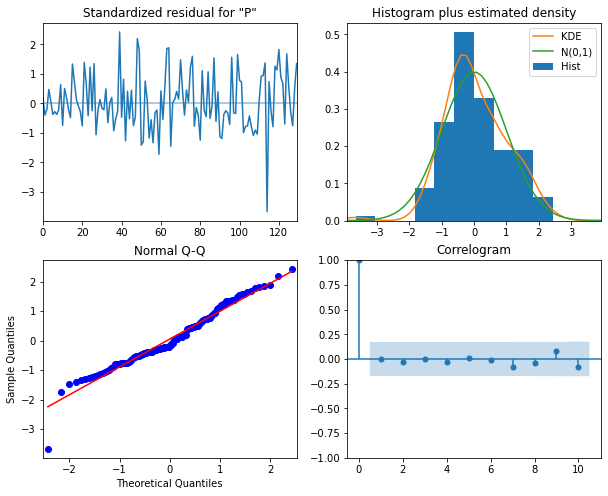

In [22]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

plt.savefig('figures/CH08_F09_peixeiro.png', dpi=300)

In [23]:
residuals = ARIMA_model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

[0.01046873 0.03574211 0.07444267 0.10132438 0.13639926 0.1914237
 0.21484054 0.28021662 0.36712092 0.31452083]


In [24]:
test = df.iloc[-12:]

test['naive_seasonal'] = df['Passengers'].iloc[120:132].values
test

,Month,Passengers,naive_seasonal
132,1960-01,417,360
133,1960-02,391,342
134,1960-03,419,406
135,1960-04,461,396
136,1960-05,472,420
137,1960-06,535,472
138,1960-07,622,548
139,1960-08,606,559
140,1960-09,508,463
141,1960-10,461,407


In [25]:
ARIMA_pred = ARIMA_model_fit.get_prediction(132, 143).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test

,Month,Passengers,naive_seasonal,ARIMA_pred
132,1960-01,417,360,422.219410
133,1960-02,391,342,410.550579
134,1960-03,419,406,461.609056
135,1960-04,461,396,457.396312
136,1960-05,472,420,481.462237
137,1960-06,535,472,530.756316
138,1960-07,622,548,606.038649
139,1960-08,606,559,615.341865
140,1960-09,508,463,525.654874
141,1960-10,461,407,467.442132


In [26]:
SARIMA_model = SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                              Passengers   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -439.122
Date:                                 Wed, 28 Jul 2021   AIC                            892.244
Time:                                         16:44:04   BIC                            911.698
Sample:                                              0   HQIC                           900.144
                                                 - 132                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2666      0.085    -14.969      0.000      -1.432      -1

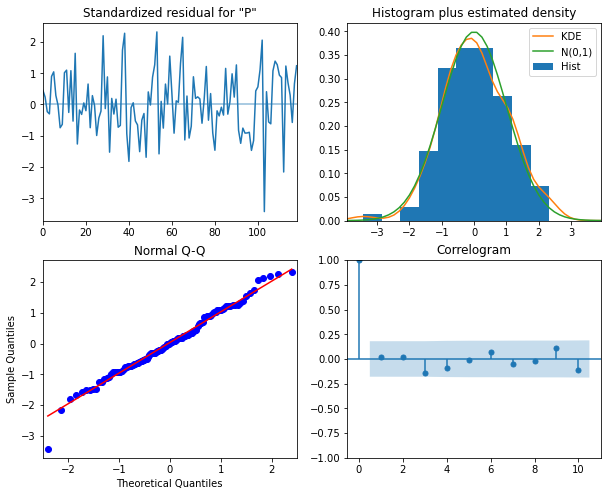

In [34]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

plt.savefig('figures/CH08_F12_peixeiro.png', dpi=300)

In [28]:
residuals = SARIMA_model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

[0.94469937 0.68870894 0.79583733 0.87369311 0.9202903  0.9441701
 0.94081314 0.95077893 0.97389656 0.89324798]


In [29]:
SARIMA_pred = SARIMA_model_fit.get_prediction(132, 143).predicted_mean

test['SARIMA_pred'] = SARIMA_pred
test

,Month,Passengers,naive_seasonal,ARIMA_pred,SARIMA_pred
132,1960-01,417,360,422.219410,418.516363
133,1960-02,391,342,410.550579,399.578257
134,1960-03,419,406,461.609056,461.313832
135,1960-04,461,396,457.396312,451.442695
136,1960-05,472,420,481.462237,473.748404
137,1960-06,535,472,530.756316,538.787832
138,1960-07,622,548,606.038649,612.466466
139,1960-08,606,559,615.341865,624.644131
140,1960-09,508,463,525.654874,520.180758
141,1960-10,461,407,467.442132,462.853236


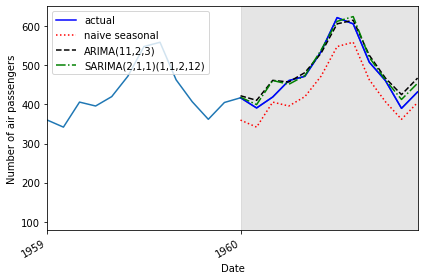

In [35]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
ax.plot(test['Passengers'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(2,1,1)(1,1,2,12)')

ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.axvspan(132, 143, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
ax.set_xlim(120, 143)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH08_F13_peixeiro.png', dpi=300)

In [31]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [32]:
mape_naive_seasonal = mape(test['Passengers'], test['naive_seasonal'])
mape_ARIMA = mape(test['Passengers'], test['ARIMA_pred'])
mape_SARIMA = mape(test['Passengers'], test['SARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA, mape_SARIMA)

9.987532920823483 3.8494699577520755 2.8494741197732933


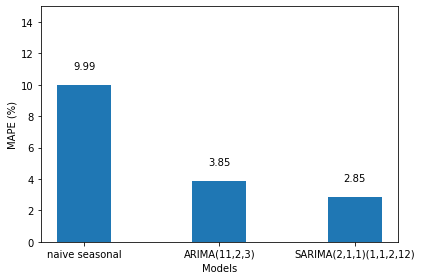

In [36]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(11,2,3)', 'SARIMA(2,1,1)(1,1,2,12)']
y = [mape_naive_seasonal, mape_ARIMA, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

plt.savefig('figures/CH08_F14_peixeiro.png', dpi=300)